In [1]:
from mobility.get_insee_data import get_insee_data
from mobility.parsers import download_work_home_flows
import mobility.radiation_model as rm
import numpy as np
import pandas as pd
import os
import time
from pathlib import Path

In [8]:
insee_data = get_insee_data()
db_actifs = insee_data["active_population"]
db_emplois = insee_data["jobs"]


Writing the INSEE (parquet/csv) files.


In [21]:
db_care = insee_data["care"]
db_care

,sink_volume
DEPCOM,
01001,20.0
01002,20.0
01004,4060.0
01005,200.0
01007,240.0
...,...
97613,80.0
97614,140.0
97615,380.0


In [11]:
db_emplois

,n_jobs_total,n_jobs_CS1,n_jobs_CS2,n_jobs_CS3,n_jobs_CS4,n_jobs_CS5,n_jobs_CS6
CODGEO,,,,,,,
01001,93.392202,15.565978,19.770984,5.234635,26.088323,9.692951,25.724097
01002,17.553800,0.000000,0.000000,0.000000,10.199848,5.201186,5.056113
01004,7903.220943,5.000000,395.268258,935.535795,2287.444604,2342.615268,1842.007953
01005,263.777236,0.000000,88.922391,34.601810,103.401287,75.464087,44.024286
01006,6.109091,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
97420,4757.097373,137.790360,449.288298,419.820471,1020.409108,1928.270800,890.916461
97421,1406.873705,197.702034,96.600775,70.766283,233.143783,380.308797,344.663647
97422,17334.990150,967.508357,1777.900445,1703.239589,3628.035455,6281.678895,3043.530726


In [16]:
db_emplois["EMPLT"] = db_emplois[
        [
            "n_jobs_CS1",
            "n_jobs_CS2",
            "n_jobs_CS3",
            "n_jobs_CS4",
            "n_jobs_CS5",
            "n_jobs_CS6",
        ]
    ].sum(axis=1)
db_emplois.reset_index(inplace=True)
db_emplois

,CODGEO,n_jobs_total,n_jobs_CS1,n_jobs_CS2,n_jobs_CS3,n_jobs_CS4,n_jobs_CS5,n_jobs_CS6,EMPLT
0,01001,93.392202,15.565978,19.770984,5.234635,26.088323,9.692951,25.724097,102.076968
1,01002,17.553800,0.000000,0.000000,0.000000,10.199848,5.201186,5.056113,20.457147
2,01004,7903.220943,5.000000,395.268258,935.535795,2287.444604,2342.615268,1842.007953,7807.871878
3,01005,263.777236,0.000000,88.922391,34.601810,103.401287,75.464087,44.024286,346.413860
4,01006,6.109091,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
34978,97420,4757.097373,137.790360,449.288298,419.820471,1020.409108,1928.270800,890.916461,4846.495498
34979,97421,1406.873705,197.702034,96.600775,70.766283,233.143783,380.308797,344.663647,1323.185319
34980,97422,17334.990150,967.508357,1777.900445,1703.239589,3628.035455,6281.678895,3043.530726,17401.893467
34981,97423,1194.948011,63.160448,74.135987,123.317424,240.518741,475.062306,235.967955,1212.162861


In [17]:
lst_departments = ["12", "48", "34", "30", "81"]# Only keep the sinks in the chosen departements
sinks_territory = db_emplois.loc[:, ["CODGEO", "EMPLT"]]
sinks_territory["DEP"] = sinks_territory["CODGEO"].str.slice(0, 2)
mask = sinks_territory["DEP"].apply(lambda x: x in lst_departments)
sinks_territory = sinks_territory.loc[mask]

sinks_territory = sinks_territory.set_index("CODGEO")
sinks_territory.rename(columns={"EMPLT": "sink_volume"}, inplace=True)
sinks_territory = sinks_territory.drop(columns=["DEP"])

In [18]:
sinks_territory

,sink_volume
CODGEO,
12001,161.372892
12002,363.113818
12003,45.123679
12004,166.229190
12006,92.590913
...,...
81322,61.921713
81323,18.654216
81324,19.706030


In [19]:

db_sport = db_sport.rename_axis('CODGEO')
db_sport

,sink_volume
CODGEO,
01001,200.0
01004,1450.0
01005,500.0
01007,350.0
01008,250.0
...,...
97613,300.0
97614,350.0
97615,550.0


In [3]:
a=pd.read_csv("examples\Millau\donneesCommunesFrance.csv")
a.shape,db_emplois.shape,db_actifs.shape
34983 

((34886, 8), (34983, 7), (34983, 7))

In [ ]:
raw_flowDT=insee_data["raw_flowDT"]
raw_flowDT

,COMMUNE,DCLT,IPONDI,TRANS
0,01001,01001,5.380466,5
1,01001,01001,5.234635,5
2,01001,01001,5.234635,5
3,01001,01001,5.092756,1
4,01001,01001,5.092756,1
...,...,...,...,...
7931857,97424,97424,5.281116,2
7931858,97424,97424,5.128822,2
7931859,97424,97424,4.980920,5
7931860,97424,97424,5.128822,5


TypeError: 'Index' object is not callable

In [ ]:
CodeCommune=db_emplois.index
CodeCommune[0]

'01001'

In [10]:
from geopy.geocoders import Nominatim
# Create a geolocator object
geolocator = Nominatim(user_agent="my-app")

# Define the region code
region_code = 'FR-I'

In [11]:
CodeCommune=db_emplois["CODGEO"]
location = lambda code: geolocator.geocode(code, addressdetails=True)
# create a list of coordinates using list comprehension
coordinates = [(code, location(code).latitude, location(code).longitude)
               for code in CodeCommune
               if location(code) is not None]
# create the dataframe from the list of coordinates
Cordonnées = pd.DataFrame(coordinates, columns=['GEOCOD', 'X', 'Y'])

GeocoderUnavailable: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=16392&format=json&limit=1&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000020980DBB340>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

In [ ]:
Cordonnées.to_csv('donneesCommunes.csv', index=False)


'01001'

In [ ]:
Cordonnées.to_csv('mobility\data\insee\commune_data\donneesCommunes.csv', index=False)

Location(Шевченківський район, Київ, 01001, Україна, (50.449763860000004, 30.4967751516129, 0.0))

In [ ]:
latitude = location.latitude
latitude

AttributeError: 'function' object has no attribute 'latitude'

In [ ]:


region_code='01001'      
# Use the geolocator object to get the location information for the region

# Extract the latitude and longitude from the location information
latitude = location.latitude
longitude = location.longitude

# Print the coordinates
print(latitude, longitude)

50.449763860000004 30.4967751516129


In [ ]:
path = "anas.zip"

In [3]:
db_emplois["EMPLT"] = db_emplois[
    [
        "n_jobs_CS1",
        "n_jobs_CS2",
        "n_jobs_CS3",
        "n_jobs_CS4",
        "n_jobs_CS5",
        "n_jobs_CS6",
    ]
].sum(axis=1)
db_emplois.reset_index(inplace=True)
sinks_territory = db_emplois.loc[:, ["CODGEO", "EMPLT"]]
sinks_territory["DEP"] = sinks_territory["CODGEO"].str.slice(0, 2)

In [4]:
sinks_territory = db_emplois.loc[:, ["CODGEO", "EMPLT"]]
sinks_territory["DEP"] = sinks_territory["CODGEO"].str.slice(0, 2)

sinks_territory

,CODGEO,EMPLT,DEP
0,01001,102.076968,01
1,01002,20.457147,01
2,01004,7807.871878,01
3,01005,346.413860,01
4,01006,0.000000,01
...,...,...,...
34978,97420,4846.495498,97
34979,97421,1323.185319,97
34980,97422,17401.893467,97
34981,97423,1212.162861,97


In [5]:
sinks_territory["DEP"] = sinks_territory["CODGEO"].str.slice(0, 2)
sinks_territory

,CODGEO,EMPLT,DEP
0,01001,102.076968,01
1,01002,20.457147,01
2,01004,7807.871878,01
3,01005,346.413860,01
4,01006,0.000000,01
...,...,...,...
34978,97420,4846.495498,97
34979,97421,1323.185319,97
34980,97422,17401.893467,97
34981,97423,1212.162861,97


In [6]:
lst_departments = ["12", "48", "34", "30", "81"]
mask = sinks_territory["DEP"].apply(lambda x: x in lst_departments)
sinks_territory = sinks_territory.loc[mask]

sinks_territory = sinks_territory.set_index("CODGEO")
sinks_territory.rename(columns={"EMPLT": "sink_volume"}, inplace=True)
sinks_territory = sinks_territory.drop(columns=["DEP"])

In [7]:
sinks_territory

,sink_volume
CODGEO,
12001,161.372892
12002,363.113818
12003,45.123679
12004,166.229190
12006,92.590913
...,...
81322,61.921713
81323,18.654216
81324,19.706030


In [8]:
plot_sinks = sinks_territory.rename(columns={"sink_volume": "volume"})
plot_sinks

,volume
CODGEO,
12001,161.372892
12002,363.113818
12003,45.123679
12004,166.229190
12006,92.590913
...,...
81322,61.921713
81323,18.654216
81324,19.706030


In [9]:
#insee_data = get_insee_data() # To get coordonnes.csv
coord=pd.read_csv("examples\Millau\donneesCommunesFrance.csv",sep=",",usecols=['NOM_COM', 'INSEE_COM','x', 'y'])
#coordonnees=insee_data["coordonnees"]
coord.set_index("INSEE_COM", inplace=True)
coord["x"] = coord["x"]
coord["y"] = coord["y"] 
coord


,NOM_COM,x,y
INSEE_COM,,,
2451,Magny-la-Fosse,721,6983
1227,Magnieu,910,6523
2061,Becquigny,731,6991
14514,Pont-l'Ã‰vÃªque,496,6915
2374,Lehaucourt,721,6978
...,...,...,...
75110,Paris 10e Arrondissement,653,6865
75113,Paris 13e Arrondissement,653,6858
75115,Paris 15e Arrondissement,650,6861


In [10]:

insee_data = get_insee_data() # To get coordonnes.csv
#coordonnees=pd.read_csv("examples\Millau\donneesCommunesFrance.csv",sep=",",usecols=['NOM_COM', 'INSEE_COM','x', 'y'])
coordonnees=insee_data["coordonnees"]
'''
def float_to_int(val):
    return int(abs(val) * 100)

# apply the function to the 'x' and 'y' columns
coordonnees['x'] = coordonnees['x'].apply(float_to_int)
coordonnees['y'] = coordonnees['y'].apply(float_to_int)
'''
coordonnees.set_index("INSEE_COM", inplace=True)
coordonnees["x"] = coordonnees["x"]
coordonnees["y"] = coordonnees["y"] 
coordonnees
                                                

Writing the INSEE (parquet/csv) files.


,NOM_COM,x,y
INSEE_COM,,,
1001,L ABERGEMENT CLEMENCIAT,46.153426,4.926114
1002,L ABERGEMENT DE VAREY,46.009188,5.428017
1004,AMBERIEU EN BUGEY,45.960848,5.372926
1005,AMBERIEUX EN DOMBES,45.996180,4.912273
1006,AMBLEON,45.749499,5.594320
...,...,...,...
97614,OUANGANI,-12.837096,45.137910
97614,OUANGANI,-12.837096,45.137910
97615,PAMANDZI,-12.796135,45.284206


In [53]:
def float_to_int(val):
    return int(abs(val) * 100)

# apply the function to the 'x' and 'y' columns
coordonnees['x'] = coordonnees['x'].apply(float_to_int)
coordonnees['y'] = coordonnees['y'].apply(float_to_int)

# change the datatype of the 'x' and 'y' columns to int64
#df = df.astype({'x': 'int64', 'y': 'int64'})

In [61]:
np.dtype(coordonnees["NOM_COM"]),np.dtype(coord["NOM_COM"])


(dtype('O'), dtype('O'))

In [15]:
if 'Magnieu' in coord['NOM_COM'] : 
    print("ok")

In [27]:
for i in range(len(plot_sinks)):
    if 'Arles' in coordonnees['NOM_COM'][i] : 
        print("ok")
    

In [ ]:
import matplotlib.pyplot as plt

title="Volume d'emplois"
plt.figure()
plt.title(title)
plt.text(
        volume_location.loc[idx, "x"],
        volume_location.loc[idx, "y"],
        volume_location.loc[idx, "NOM_COM"],
    )

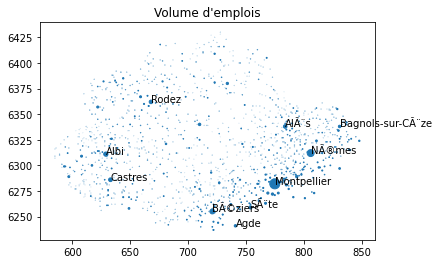

In [134]:
import matplotlib.pyplot as plt
volume_location=plot_sinks
coordinates=coord
n_locations=10
title="Volume d'emplois"
plt.figure()
plt.title(title)
# Normalization
volume_location["volume"] = (
    100
    * (volume_location["volume"] - volume_location["volume"].min())
    / volume_location["volume"].max()
)

# Plot the locations
volume_location = pd.merge(
    volume_location, coordinates, left_index=True, right_index=True
)
# Check for duplicate index values


plt.scatter(volume_location["x"], volume_location["y"], s=volume_location["volume"])

# n_locations biggest location to display
volume_location.sort_values(by="volume", inplace=True)
idx_show = volume_location.iloc[-n_locations:].index
index_duplicates = volume_location.index.duplicated()

volume_location1 = volume_location[~index_duplicates].copy()

volume_location.sort_index(inplace=True)
for idx in idx_show:
    plt.text(
        volume_location.loc[idx, "x"],
        volume_location.loc[idx, "y"],
        volume_location.loc[idx, "NOM_COM"],
    )


In [ ]:
i=0
for idx in idx_show:
    i+=1
    print(i)
    print(volume_location2.loc[idx, "NOM_COM"])

In [143]:
coordonnees

,NOM_COM,x,y
INSEE_COM,,,
1001,L ABERGEMENT CLEMENCIAT,46.153426,4.926114
1002,L ABERGEMENT DE VAREY,46.009188,5.428017
1004,AMBERIEU EN BUGEY,45.960848,5.372926
1005,AMBERIEUX EN DOMBES,45.996180,4.912273
1006,AMBLEON,45.749499,5.594320
...,...,...,...
97614,OUANGANI,-12.837096,45.137910
97614,OUANGANI,-12.837096,45.137910
97615,PAMANDZI,-12.796135,45.284206


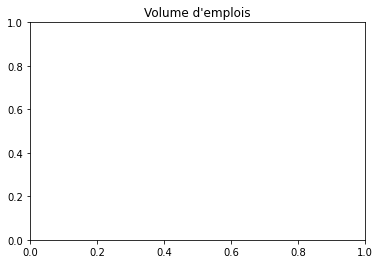

In [150]:
import matplotlib.pyplot as plt
volume_location=plot_sinks
coordinates=coordonnees
n_locations=10
title="Volume d'emplois"
plt.figure()
plt.title(title)
# Normalization
volume_location["volume"] = (
    100
    * (volume_location["volume"] - volume_location["volume"].min())
    / volume_location["volume"].max()
)

# Plot the locations
volume_location = pd.merge(
    volume_location, coordinates, left_index=True, right_index=True
)


# n_locations biggest location to display
volume_location.sort_values(by="volume", inplace=True)
idx_show = volume_location.iloc[-n_locations:].index



volume_location2 = pd.merge(volume_location, coord, left_index=True, right_index=True)
volume_location2.sort_index(inplace=True)
# Check for duplicate index values
index_duplicates = volume_location.index.duplicated()
# Remove rows with duplicate index values
volume_location = volume_location[~index_duplicates].copy()
index_duplicates2 = volume_location2.index.duplicated()
# Remove rows with duplicate index values
volume_location2 = volume_location2[~index_duplicates2].copy()

#np.dtype(volume_location1['x']),np.dtype(volume_location2['x'])

#volume_location1['NOM_COM'],volume_location2['NOM_COM']


In [153]:
volume_location

,volume,NOM_COM,x,y
81172,0.000000,MONTAURIOL,44.081551,2.327262
34253,0.000000,ST FELIX DE L HERAS,43.839377,3.314536
48185,0.000000,LES SALELLES,44.484739,3.274131
81085,0.000000,ESCROUX,43.757587,2.641915
81122,0.000000,LACAPELLE PINET,44.067708,2.354347
...,...,...,...,...
81065,13.915125,CASTRES,43.615651,2.237872
81004,18.126588,ALBI,43.925821,2.146863
34032,23.419380,BEZIERS,43.347588,3.230768
30189,47.905265,NIMES,43.844938,4.348068


In [154]:
volume_location['NOM_COM'] = volume_location['NOM_COM'].str.replace(' ', '').str.replace('\'', '')

volume_location

,volume,NOM_COM,x,y
81172,0.000000,MONTAURIOL,44.081551,2.327262
34253,0.000000,STFELIXDELHERAS,43.839377,3.314536
48185,0.000000,LESSALELLES,44.484739,3.274131
81085,0.000000,ESCROUX,43.757587,2.641915
81122,0.000000,LACAPELLEPINET,44.067708,2.354347
...,...,...,...,...
81065,13.915125,CASTRES,43.615651,2.237872
81004,18.126588,ALBI,43.925821,2.146863
34032,23.419380,BEZIERS,43.347588,3.230768
30189,47.905265,NIMES,43.844938,4.348068


In [152]:
for i in range(len(volume_location)):
    for j in range (len(volume_location2)):
        if volume_location.index[i]==volume_location2.index[j]:
            print(volume_location.head())
            volume_location['NOM_COM']=volume_location2['NOM_COM']

       volume              NOM_COM          x         y
81172     0.0           MONTAURIOL  44.081551  2.327262
34253     0.0  ST FELIX DE L HERAS  43.839377  3.314536
48185     0.0         LES SALELLES  44.484739  3.274131
81085     0.0              ESCROUX  43.757587  2.641915
81122     0.0      LACAPELLE PINET  44.067708  2.354347


KeyError: 'NOM_COM'

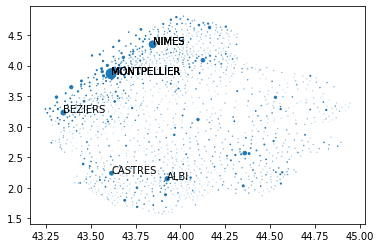

In [155]:
plt.scatter(volume_location["x"], volume_location["y"], s=volume_location["volume"])

for idx in idx_show:
    plt.text(
        volume_location.loc[idx, "x"],
        volume_location.loc[idx, "y"],
        volume_location.loc[idx, "NOM_COM"],
    )


In [133]:
import matplotlib.pyplot as plt

title="Volume d'emplois"
plt.figure()
plt.title(title)
plt.text(
        volume_location2.loc[idx, "x"],
        volume_location2.loc[idx, "y"],
        volume_location2.loc[idx, "NOM_COM"],
    )

Text(775, 6282, 'Montpellier')

ValueError: Image size of 259563x1365997 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 1 Axes>

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

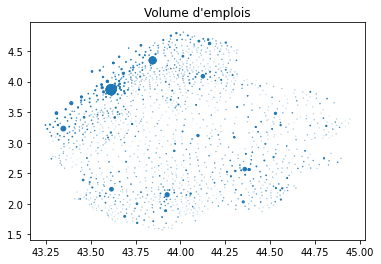

In [126]:
import matplotlib.pyplot as plt

volume_location = plot_sinks
coordinates = coordonnees
n_locations = 10
title = "Volume d'emplois"
plt.figure()
plt.title(title)

# Normalization
volume_location["volume"] = (
    100
    * (volume_location["volume"] - volume_location["volume"].min())
    / volume_location["volume"].max()
)

# Plot the locations
volume_location = pd.merge(
    volume_location, coordinates, left_index=True, right_index=True
)

# Check for duplicate index values
index_duplicates = volume_location.index.duplicated()

# Create a new DataFrame without duplicate index values
volume_location1 = volume_location[~index_duplicates].copy()

plt.scatter(volume_location["x"], volume_location["y"], s=volume_location["volume"])

# n_locations biggest location to display
volume_location.sort_values(by="volume", inplace=True)
idx_show = volume_location.iloc[-n_locations:].index

volume_location.sort_index(inplace=True)
for idx in idx_show:
    if not index_duplicates[idx].any():
        plt.text(
            volume_location.loc[idx, "x"],
            volume_location.loc[idx, "y"],
            volume_location.loc[idx, "NOM_COM"],
        )

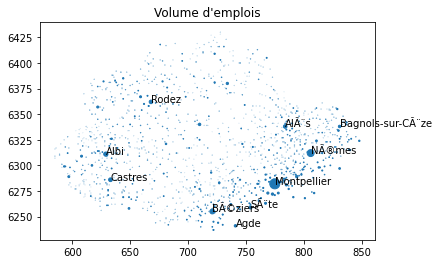

In [58]:
import matplotlib.pyplot as plt
import pandas as pd

volume_location = plot_sinks
coordinates = coord
n_locations = 10
title = "Volume d'emplois"
plt.figure()
plt.title(title)

# Normalization
volume_location["volume"] = (
    100
    * (volume_location["volume"] - volume_location["volume"].min())
    / volume_location["volume"].max()
)

# Plot the locations
volume_location = pd.merge(volume_location, coordinates, left_index=True, right_index=True)
plt.scatter(volume_location["x"], volume_location["y"], s=volume_location["volume"])

# n_locations biggest location to display
volume_location.sort_values(by="volume", inplace=True)
idx_show = volume_location.iloc[-n_locations:].index

volume_location.sort_index(inplace=True)
for idx in idx_show:
    plt.text(
        volume_location.loc[idx, "x"],
        volume_location.loc[idx, "y"],
        volume_location.loc[idx, "NOM_COM"],
    )

plt.show()


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

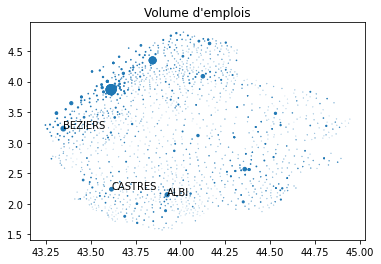

In [12]:
#df1=coordonnees.dropna(subset=['NOM_COM','x', 'y'])
rm.plot_volume(plot_sinks, coordonnees, n_locations=10, title="Volume d'emplois")

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

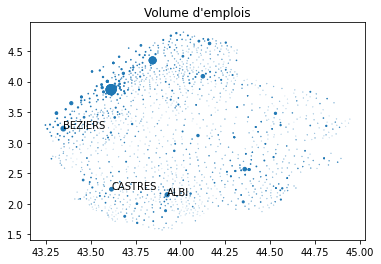

In [12]:
rm.plot_volume(plot_sinks, df1, n_locations=10, title="Volume d'emplois")

In [ ]:
location = lambda code: geolocator.geocode(code, addressdetails=True)
# create a list of coordinates using list comprehension
coordinates = [(code, location(code).latitude, location(code).longitude)
               for code in CodeCommune
               if location(code) is not None]
# create the dataframe from the list of coordinates
Cordonnées = pd.DataFrame(coordinates, columns=['GEOCOD', 'X', 'Y'])

In [ ]:
#WORK_HOME_FLUXES_CSV = download_work_home_flows()
#data_folder_path = Path(os.path.dirname("examples/Millau/"))
#file_path = os.path.join(data_folder_path, WORK_HOME_FLUXES_CSV)
data_folder_path = Path(os.path.dirname("mobility")) / "mobility/data/insee"
file_path=data_folder_path / "work_home_flows/FD_MOBPRO_2019.csv"
# Import the INSEE data on the work-home mobility on Millau
file_path

WindowsPath('mobility/data/insee/work_home_flows/FD_MOBPRO_2019.csv')

In [ ]:
raw_flowDT = pd.read_csv(
    file_path,
    sep=";",
    usecols=["COMMUNE", "DCLT", "IPONDI", "TRANS"],
    dtype={"COMMUNE": str, "DCLT": str, "IPONDI": float, "TRANS": int},
)

In [ ]:
raw_flowDT

,COMMUNE,DCLT,IPONDI,TRANS
0,01001,01001,5.380466,5
1,01001,01001,5.234635,5
2,01001,01001,5.234635,5
3,01001,01001,5.092756,1
4,01001,01001,5.092756,1
...,...,...,...,...
7931857,97424,97424,5.281116,2
7931858,97424,97424,5.128822,2
7931859,97424,97424,4.980920,5
7931860,97424,97424,5.128822,5


In [ ]:
# Only keep the flows in the given departments
raw_flowDT["DEP"] = raw_flowDT["COMMUNE"].str.slice(0, 2)
raw_flowDT["DEP2"] = raw_flowDT["DCLT"].str.slice(0, 2)
mask = raw_flowDT["DEP"].apply(lambda x: x in lst_departments)
mask2 = raw_flowDT["DEP2"].apply(lambda x: x in lst_departments)
raw_flowDT = raw_flowDT.loc[mask]
raw_flowDT = raw_flowDT.loc[mask2]
raw_flowDT

,COMMUNE,DCLT,IPONDI,TRANS,DEP,DEP2
458586,12001,12001,5.054987,1,12,12
458587,12001,12001,4.844917,5,12,12
458588,12001,12001,5.274166,5,12,12
458589,12001,12001,5.274166,1,12,12
458590,12001,12001,5.054987,5,12,12
...,...,...,...,...,...,...
6126192,81326,81326,4.787744,5,81,81
6126193,81326,81326,5.112942,5,81,81
6126194,81326,81326,5.226177,2,81,81
6126195,81326,81326,5.341921,1,81,81


In [ ]:
mask

0          False
1          False
2          False
3          False
4          False
           ...  
7931857    False
7931858    False
7931859    False
7931860    False
7931861    False
Name: DEP, Length: 7931862, dtype: bool

In [ ]:
3.687*0.611 

2.252757

In [ ]:
df=pd.read_csv("dossier_complet.csv")
df

ParserError: Error tokenizing data. C error: Expected 1 fields in line 4, saw 22


In [12]:
import pandas as pd
#df=pd.read_csv("mobility\data\insee\commune_data\donneesCommunes.csv")
df=pd.read_csv("mobility\data\insee\commune_data\donneesCommunes.csv",sep=",",
    usecols=['code_commune_INSEE', 'nom_commune_postal','latitude', 'longitude'],
    dtype={"code_commune_INSEE": str, "nom_commune_postal": str, "latitude": float, "longitude": float},)
df.shape,df.head(5)

((39201, 4),
   code_commune_INSEE       nom_commune_postal   latitude  longitude
 0               1001  L ABERGEMENT CLEMENCIAT  46.153426   4.926114
 1               1002    L ABERGEMENT DE VAREY  46.009188   5.428017
 2               1004        AMBERIEU EN BUGEY  45.960848   5.372926
 3               1005      AMBERIEUX EN DOMBES  45.996180   4.912273
 4               1006                  AMBLEON  45.749499   5.594320)

In [18]:
df1=df.dropna(subset=['code_commune_INSEE','latitude', 'longitude'])
df1.shape

(38932, 4)

In [20]:
import pandas as pd
import geopy.distance
from scipy.spatial.distance import cdist
df1=df.dropna(subset=['code_commune_INSEE','latitude', 'longitude'])
distances = cdist(df1[['latitude', 'longitude']], df1[['latitude', 'longitude']], 'euclidean')

In [30]:
distances[0].sum(),distances[1].sum()

(161320.72864312486, 171550.29784047304)

In [23]:
distances.shape,distances
len(distances)

38932

In [37]:
distances[4].sum()/len(distances)

4.561934890895878

In [31]:
import pandas as pd
import geopy.distance
from scipy.spatial.distance import cdist
def internal_distances(coordonnees):
    # Drop Nan value 
    df1=df.dropna(subset=['code_commune_INSEE','latitude', 'longitude'])
    distances = cdist(df1[['latitude', 'longitude']], df1[['latitude', 'longitude']], 'euclidean')
    internal_distances = []
    for i in range(len(distances)):
        internal_distances.append({'code_commune_INSEE': df1.iloc[i]['code_commune_INSEE'], 'internal_distance': (distances[i].sum())/len(distances)})

    # Convert the results to a DataFrame
    internal_distances = pd.DataFrame(internal_distances)
    return internal_distances

,code_commune_INSEE,internal_distance
0,1001,4.143654
1,1002,4.406409
2,1004,4.390237
3,1005,4.173164
4,1006,4.561935
...,...,...
38927,97614,73.249453
38928,97614,73.249453
38929,97615,73.300568
38930,97616,73.257843


In [12]:
distances.shape
internal_distances = []
import numpy as np
for i in range(len(df)):
    neighboring_distances = []
    for j in range(len(df)):
        if j != i and distances[i,j] != np.NaN:
            neighboring_distances.append(distances[i,j])
    if len(neighboring_distances) > 0:
        internal_distances.append({'code_commune_INSEE': df.iloc[i]['code_commune_INSEE'], 'internal_distance': sum(neighboring_distances) / len(neighboring_distances)})
    else:
        internal_distances.append({'code_commune_INSEE': df.iloc[i]['code_commune_INSEE'], 'internal_distance': 0})

# Convert the results to a DataFrame
internal_distances_df = pd.DataFrame(internal_distances)

39201

In [2]:
from math import radians, sin, cos, sqrt, atan2

# Define a function to calculate the distance between two points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in kilometers

    lat1_rad = radians(lat1)
    lon1_rad = radians(lon1)
    lat2_rad = radians(lat2)
    lon2_rad = radians(lon2)

    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad

    a = sin(dlat / 2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance


In [17]:
distances = pd.DataFrame(index=df.index, columns=df.index)
distances

MemoryError: Unable to allocate 11.4 GiB for an array with shape (39201, 39201) and data type object

In [3]:
# Calculate the distances between all pairs of communes using the Haversine formula
distances = pd.DataFrame(index=df.index, columns=df.index)
for i in range(len(df)):
    for j in range(len(df)):
        distances.iloc[i,j] = haversine(df.iloc[i]['latitude'], df.iloc[i]['longitude'], df.iloc[j]['latitude'], df.iloc[j]['longitude'])

In [ ]:
# Calculate the internal distance for each commune
internal_distances = []
for i in range(len(df)):
    neighboring_distances = []
    for j in range(len(df)):
        if j != i:
            neighboring_distances.append(distances.iloc[i,j])
    if len(neighboring_distances) > 0:
        internal_distances.append({'code_commune_INSEE': df.iloc[i]['code_commune_INSEE'], 'internal_distance': sum(neighboring_distances) / len(neighboring_distances)})
    else:
        internal_distances.append({'code_commune_INSEE': df.iloc[i]['code_commune_INSEE'], 'internal_distance': 0})

# Convert the results to a DataFrame
internal_distances_df = pd.DataFrame(internal_distances)

In [11]:
import pandas as pd
import geopy.distance
from scipy.spatial.distance import cdist
distances = cdist(df[['latitude', 'longitude']], df[['latitude', 'longitude']], 'euclidean')

In [2]:
# Calculate Internal Distances
from scipy.spatial.distance import cdist
def internal_distances(data):
    # Drop Nan value 
    df1=data.dropna(subset=['INSEE_COM','x', 'y'])
    distances = cdist(df1[['x', 'y']], df1[['x', 'y']], 'euclidean')
    distance_interne = []
    for i in range(len(distances)):
        distance_interne.append({'INSEE_COM': df1.iloc[i]['INSEE_COM'], 'distance_interne': (distances[i].sum())/len(distances)})

    # Convert the results to a DataFrame
    distance_interne = pd.DataFrame(distance_interne)
    return distance_interne

In [3]:
def get_data_for_model(
    lst_departments,
    alpha=0,
    beta=1,
):
  
    # ===================
    # IMPORT AND PROCESS THE DATA

    # Import the data (active population and jobs)
    insee_data = get_insee_data()
    db_actifs = insee_data["active_population"]
    db_emplois = insee_data["jobs"]
    raw_flowDT=insee_data["raw_flowDT"]
    coordonnees=insee_data["coordonnees"]
    surf=insee_data["coordonnees"]
   

    db_emplois["EMPLT"] = db_emplois[
        [
            "n_jobs_CS1",
            "n_jobs_CS2",
            "n_jobs_CS3",
            "n_jobs_CS4",
            "n_jobs_CS5",
            "n_jobs_CS6",
        ]
    ].sum(axis=1)
    db_emplois.reset_index(inplace=True)

    db_actifs["ACT"] = db_actifs[
        [
            "active_pop_CS1",
            "active_pop_CS2",
            "active_pop_CS3",
            "active_pop_CS4",
            "active_pop_CS5",
            "active_pop_CS6",
        ]
    ].sum(axis=1)
    db_actifs.reset_index(inplace=True)

    # Only keep the sinks in the chosen departements
    sinks_territory = db_emplois.loc[:, ["CODGEO", "EMPLT"]]
    sinks_territory["DEP"] = sinks_territory["CODGEO"].str.slice(0, 2)
    mask = sinks_territory["DEP"].apply(lambda x: x in lst_departments)
    sinks_territory = sinks_territory.loc[mask]

    sinks_territory = sinks_territory.set_index("CODGEO")
    sinks_territory.rename(columns={"EMPLT": "sink_volume"}, inplace=True)
    sinks_territory = sinks_territory.drop(columns=["DEP"])

    # Only keep the sinks in the chosen departements
    sources_territory = db_actifs.loc[:, ["CODGEO", "ACT"]]
    sources_territory["DEP"] = sources_territory["CODGEO"].str.slice(0, 2)
    mask = sources_territory["DEP"].apply(lambda x: x in lst_departments)
    sources_territory = sources_territory.loc[mask]

    sources_territory = sources_territory.set_index("CODGEO")
    sources_territory = sources_territory.drop(columns=["DEP"])
    sources_territory.rename(columns={"ACT": "source_volume"}, inplace=True)

    data_folder_path = Path(os.path.dirname("examples/Millau/"))

    # Import the INSEE data on the work-home mobility on Millau
    # Only keep the flows in the given departments

    raw_flowDT["DEP"] = raw_flowDT["COMMUNE"].str.slice(0, 2)
    raw_flowDT["DEP2"] = raw_flowDT["DCLT"].str.slice(0, 2)
    mask = raw_flowDT["DEP"].apply(lambda x: x in lst_departments)
    mask2 = raw_flowDT["DEP2"].apply(lambda x: x in lst_departments)
    raw_flowDT = raw_flowDT.loc[mask]
    raw_flowDT = raw_flowDT.loc[mask2]

    # Import the geographic data on the work-home mobility on Millau
    '''
    coordonnees = pd.read_csv(
        data_folder_path / communes_coordinates_csv,
        sep=",",
        usecols=["NOM_COM", "INSEE_COM", "x", "y"],
        dtype={"INSEE_COM": str},
    )
    '''
    
 
    print(surf.head())
    surfaces = internal_distances(surf)
    surfaces.set_index("INSEE_COM", inplace=True)

    coordonnees.set_index("INSEE_COM", inplace=True)
    coordonnees["x"] = coordonnees["x"]
    coordonnees["y"] = coordonnees["y"] 

    # Compute the distance between cities
    #    distance between i and j = (x_i - x_j)**2 + (y_i - y_j)**2
    lst_communes = sources_territory.index.to_numpy()
    idx_from_to = np.array(np.meshgrid(lst_communes, lst_communes)).T.reshape(-1, 2)
    idx_from = idx_from_to[:, 0]
    idx_to = idx_from_to[:, 1]
    costs_territory = pd.DataFrame(
        {"from": idx_from, "to": idx_to, "cost": np.zeros(idx_to.shape[0])}
    )
    costs_territory = pd.merge(
        costs_territory, coordonnees, left_on="from", right_index=True
    )
    costs_territory.rename(columns={"x": "from_x", "y": "from_y"}, inplace=True)
    costs_territory = pd.merge(
        costs_territory, coordonnees, left_on="to", right_index=True
    )
    costs_territory.rename(columns={"x": "to_x", "y": "to_y"}, inplace=True)

    costs_territory = pd.merge(
        costs_territory, surfaces, left_on="from", right_index=True
    )

    costs_territory["cost"] = np.sqrt(
        (costs_territory["from_x"] / 1000 - costs_territory["to_x"] / 1000) ** 2
        + (costs_territory["from_y"] / 1000 - costs_territory["to_y"] / 1000) ** 2
    )

    # distance if the origin and the destination is the same city
    # is internal distance = 128*r / 45*pi
    # where r = sqrt(surface of the city)/pi
    mask = costs_territory["from"] != costs_territory["to"]
    costs_territory["cost"].where(
        mask, other=costs_territory["distance_interne"], inplace=True
    )

    return (
        sources_territory,
        sinks_territory,
        costs_territory,
        coordonnees,
        raw_flowDT,
    )

In [4]:
lst_departments = ["12", "48", "34", "30", "81"]

# GET DATA
(
    sources_territory,
    sinks_territory,
    costs_territory,
    coordonnees,
    raw_flowDT,
) = get_data_for_model(lst_departments)

Writing the INSEE (parquet/csv) files.
  INSEE_COM                  NOM_COM          x         y
0      1001  L ABERGEMENT CLEMENCIAT  46.153426  4.926114
1      1002    L ABERGEMENT DE VAREY  46.009188  5.428017
2      1004        AMBERIEU EN BUGEY  45.960848  5.372926
3      1005      AMBERIEUX EN DOMBES  45.996180  4.912273
4      1006                  AMBLEON  45.749499  5.594320


In [17]:
(total_flows, source_rest_volume, sink_rest_volume) = rm.iter_radiation_model(
    sources_territory,
    sinks_territory,
    costs_territory,
    alpha=0,
    beta=1,
    plot=False,
)

Iteration n°1 of the radiation model
Iteration n°2 of the radiation model
Iteration n°3 of the radiation model


In [33]:
plot_flows = total_flows.reset_index()
plot_sources = sources_territory
flows=plot_flows
coordinates=coord
sources=None
n_flows=100,
n_locations=5
size=1
title=( "(1) Flux domicile-travail générés par le modèle" " - alpha = {} - beta = {}").format(0, 1)


In [34]:
plot_flows = total_flows.reset_index()
plot_sources = sources_territory
flows=plot_flows
coordinates=coord
sources=None
n_flows=100,
n_locations=5
size=1
title=( "(1) Flux domicile-travail générés par le modèle" " - alpha = {} - beta = {}").format(0, 1)

flows["flow_volume"] = (
    size
    * 100
    * (flows["flow_volume"] - flows["flow_volume"].min())
    / flows["flow_volume"].max()
)


In [35]:
flows = pd.merge(flows, coordonnees, left_on="from", right_index=True)
    # Check for duplicate index values
#index_duplicates = flows.index.duplicated()
# Remove rows with duplicate index values
#flows = flows[~index_duplicates].copy()
#flows['NOM_COM'] = flows['NOM_COM'].str.replace(' ', '').str.replace('\'', '')
flows.rename({"x": "from_x", "y": "from_y"}, axis=1, inplace=True)
flows = pd.merge(flows, coordinates, left_on="to", right_index=True)
flows.rename({"x": "to_x", "y": "to_y"}, axis=1, inplace=True)
flows.sort_values(by="flow_volume", ascending=False, inplace=True)
#idx_show = flows.iloc[:n_flows].index
idx_show = flows.iloc[:int(n_flows)].index



TypeError: int() argument must be a string, a bytes-like object or a real number, not 'tuple'

In [38]:
plot_flows = total_flows.reset_index()
plot_sources = sources_territory
flows=plot_flows
coordinates=coord
sources=None
n_flows=100
n_locations=5
size=1
title=( "(1) Flux domicile-travail générés par le modèle" " - alpha = {} - beta = {}").format(0, 1)

flows["flow_volume"] = (
    size
    * 100
    * (flows["flow_volume"] - flows["flow_volume"].min())
    / flows["flow_volume"].max()
)
flows = pd.merge(flows, coordonnees, left_on="from", right_index=True)
    # Check for duplicate index values
index_duplicates = flows.index.duplicated()
# Remove rows with duplicate index values
flows = flows[~index_duplicates].copy()
flows['NOM_COM'] = flows['NOM_COM'].str.replace(' ', '').str.replace('\'', '')
flows.rename({"x": "from_x", "y": "from_y"}, axis=1, inplace=True)
flows = pd.merge(flows, coordinates, left_on="to", right_index=True)
flows.rename({"x": "to_x", "y": "to_y"}, axis=1, inplace=True)
flows.sort_values(by="flow_volume", ascending=False, inplace=True)
idx_show = flows.iloc[:n_flows].index


In [41]:
idx_show

Int64Index([2201779, 2202831, 2202731, 2570952, 2203923, 1166991, 2203131,
             796627,   27332, 2203791, 2203107, 2203035, 2571777, 2201780,
            2203079, 2571453, 2203719, 2204075, 2203243, 2202963,   31541,
            2203095, 2572611, 2571027, 2711185, 2203507,  796614, 2572710,
            2571090, 2202983, 2237792, 1167114, 1167158, 2571489, 2337454,
            2202911, 2202955, 2572023, 2571324,  796817, 1360411, 2465776,
            2572711, 2162209, 2554215, 2203567, 1842532, 2376890, 2101540,
            2203747,   27330, 2571171, 1781648, 2571129, 2201781,  796660,
            1842533, 2203811, 2572712, 2204027, 2769187,  796706,  796777,
            2571198, 2572020, 2465918, 1842355, 1842241, 2203955, 2337538,
            1842273,  448416, 2203315, 2202691, 2203267, 1289867, 2162151,
            2237843, 2237833,   27281, 2101541,   31542, 2571015,  318223,
             637540, 2210556, 2102136,   27297, 2203491, 2572713, 2162075,
            2203687, 2571

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: setting an array element with a sequence.

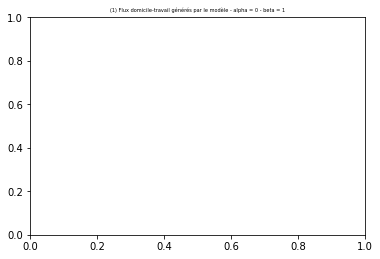

In [43]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6 * size, 4 * size))
plt.title(title, fontsize=5 * size)
# Plot the flows
for idx in idx_show:
    plt.plot(
        [flows.loc[idx, "from_x"], flows.loc[idx, "to_x"]],
        [flows.loc[idx, "from_y"], flows.loc[idx, "to_y"]],
        linewidth=flows.loc[idx, "flow_volume"],
        color="lightblue",
        zorder=0,
    )

if sources is None:
    # Plot the locations based on the internal flow
    internal_flows = flows.loc[flows["from"] == flows["to"]]
    # Normalization
    internal_flows.loc[:, "flow_volume"] = (
        size**2
        * 100
        * (
            internal_flows.loc[:, "flow_volume"]
            - internal_flows["flow_volume"].min()
        )
        / internal_flows["flow_volume"].max()
    )
    plt.scatter(
        internal_flows["from_x"],
        internal_flows["from_y"],
        s=internal_flows["flow_volume"],
        zorder=1,
    )

    # n_locations biggest location to display
    internal_flows.sort_values(by="flow_volume", ascending=False, inplace=True)

    temp = internal_flows.iloc[:n_locations].index
    idx_show = internal_flows.loc[temp, "from"].to_numpy()
    for idx in idx_show:
        plt.text(
            coordinates.loc[idx, "x"],
            coordinates.loc[idx, "y"],
            coordinates.loc[idx, "NOM_COM"][0:14],
            fontsize=5 * size,
        )
else:
    # Normalization
    sources["source_volume"] = (
        size**2
        * 100
        * (sources["source_volume"] - sources["source_volume"].min())
        / sources["source_volume"].max()
    )

    # Plot the locations
    sources = pd.merge(sources, coordinates, left_index=True, right_index=True)
    plt.scatter(sources["x"], sources["y"], s=sources["source_volume"], zorder=1)

    # n_locations biggest location to display
    sources.sort_values(by="source_volume", inplace=True)
    idx_show = sources.iloc[-n_locations:].index

    sources.sort_index(inplace=True)
    for idx in idx_show:
        plt.text(
            sources.loc[idx, "x"],
            sources.loc[idx, "y"],
            sources.loc[idx, "NOM_COM"][0:14],
            fontsize=5 * size,
        )
